In [30]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
# pd.set_option("display.max_columns", 50)

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

In [19]:
# Pickling Call Volume 2018 df
redo_pickle = False

if redo_pickle == True:
    with open('hourly_call_volume_medical_2018.pickle','wb') as f:
        pickle.dump(hourly_call_volume_medical_2018,f)
        
if redo_pickle == False:
    with open('hourly_call_volume_medical_2018.pickle','rb') as f:
        hourly_call_volume_medical_2018 = pickle.load(f)

In [20]:
# Formatting hourly call volume for time series properly
hourly_call_volume_medical_2018 = hourly_call_volume_medical_2018.asfreq('H',fill_value=0)

In [21]:
# Pickling Unavailable Units 2018 df
redo_pickle = False

if redo_pickle == True:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','wb') as f:
        pickle.dump(unavailable_units_15_min_int_counts_2018_df,f)
        
if redo_pickle == False:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','rb') as f:
        unavailable_units_15_min_int_counts_2018_df = pickle.load(f)

## Analysis for SARIMA modeling
- Looking for seasonality and other trends to determine correct hyper parameters for models

### Hourly Lag Autocorrelation

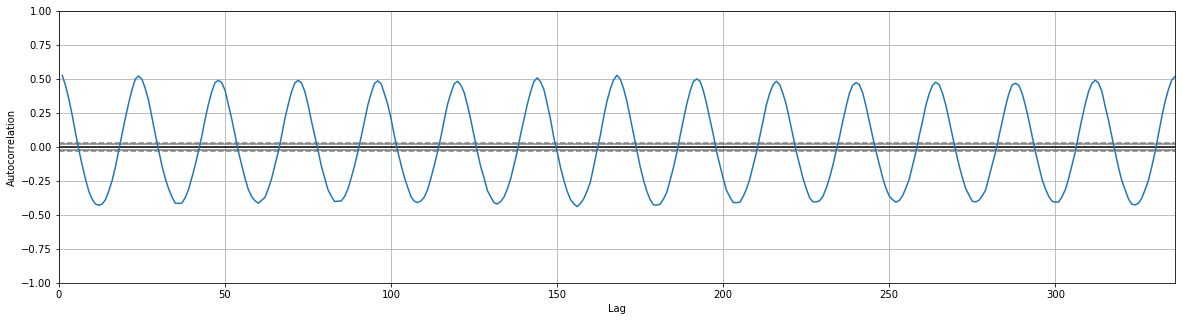

In [24]:
# Plotting Premade Autcorrelation Function (ACF)
plt.figure(figsize=(20,5))
autocorrelation_plot(hourly_call_volume_medical_2018)
plt.xlim(0,24*14); # Showing Two weeks lags

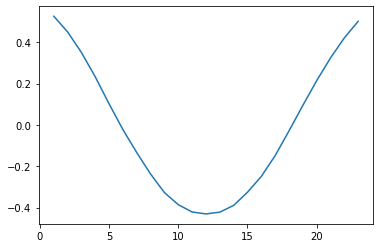

In [310]:
# Replicating Code for Premade ACF

# Manually Calculating lags from 1 to 24 hours
lag_list = []
for i in range(1,24):
    lag_list.append(hourly_call_volume_medical_2018.autocorr(lag=i))
    
# Manually Plotting correlations with lags
sns.lineplot(range(1,24),lag_list)

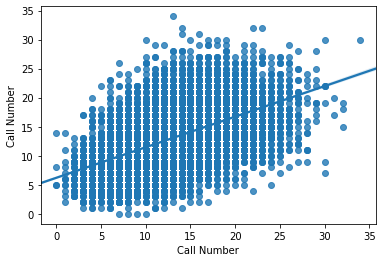

In [343]:
# Plotting correlation scatter plot with lag of 1: 
# This is another visualization to show how hourly 
# call volume is correlated with a lag of one hour
sns.regplot(hourly_call_volume_medical_2018,hourly_call_volume_medical_2018.shift(periods=1, fill_value=np.nan))

### Hourly Decomposition

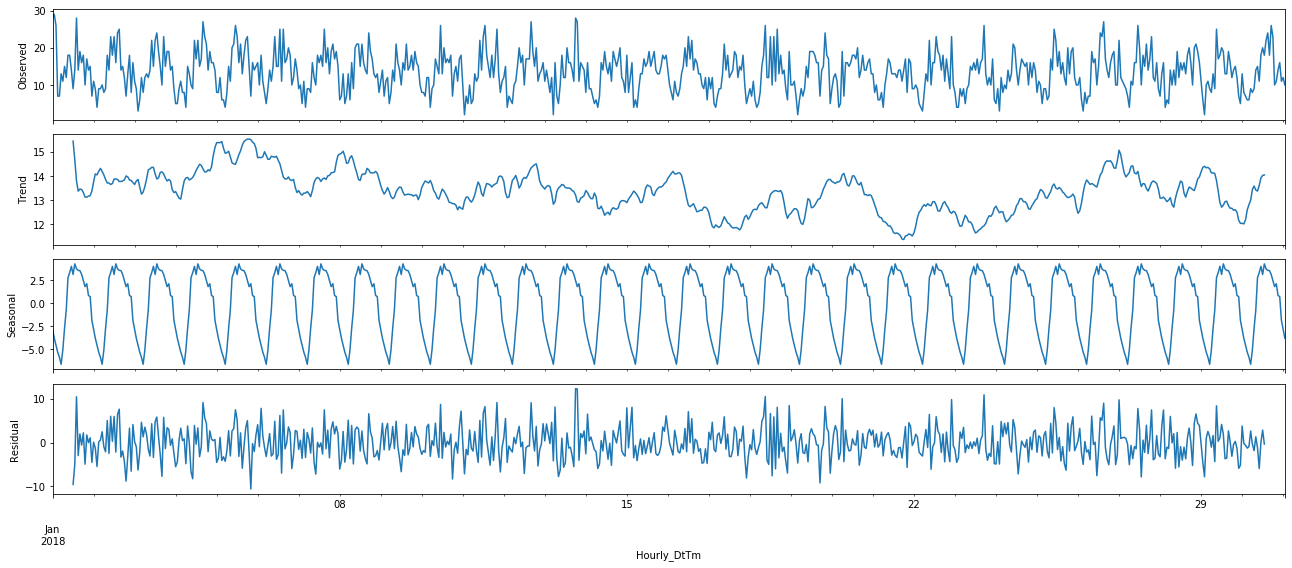

In [395]:
# Decomposing Jan 2018 to find the underlying seasonality(daily high and low) and trend(no obvious one)
decomposition = seasonal_decompose(hourly_call_volume_medical_2018[:722], model='additive')

decomposition.plot();

### Hourly Violin Plot

In [520]:
violin_hourly_call_volume_medical_2018 = hourly_call_volume_medical_2018.copy()

In [521]:
violin_hourly_call_volume_medical_2018.index = hourly_call_volume_medical_2018.index.hour

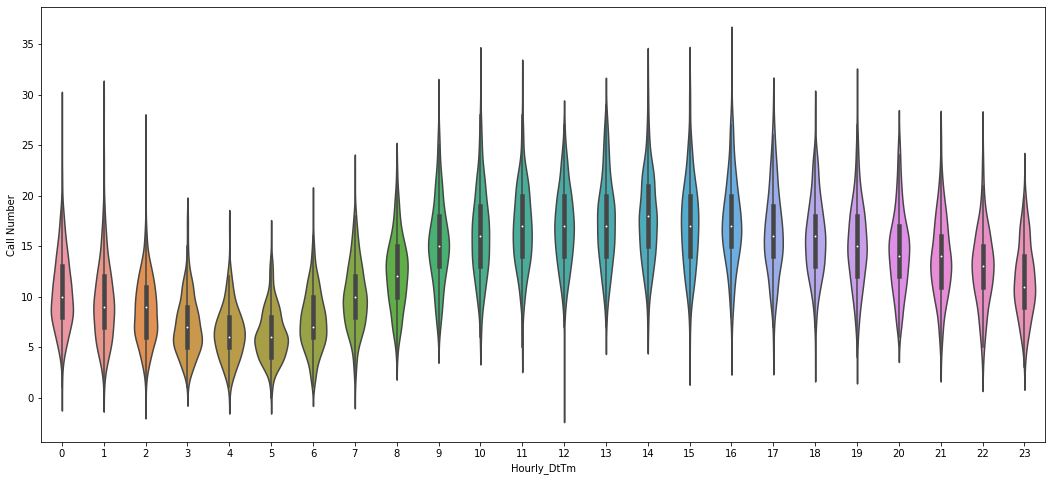

In [522]:
sns.violinplot(x=violin_hourly_call_volume_medical_2018.index, y=violin_hourly_call_volume_medical_2018)

### Daily Lag Autocorrelation

In [22]:
# resample all store data to average daily sales
daily_average_call_volume_medical_2018 = hourly_call_volume_medical_2018.resample('D').mean()

daily_average_call_volume_medical_2018.head(10)

Hourly_DtTm
2018-01-01    15.791667
2018-01-02    13.875000
2018-01-03    14.208333
2018-01-04    14.166667
2018-01-05    14.500000
2018-01-06    14.791667
2018-01-07    13.958333
2018-01-08    13.708333
2018-01-09    13.583333
2018-01-10    13.416667
Freq: D, Name: Call Number, dtype: float64

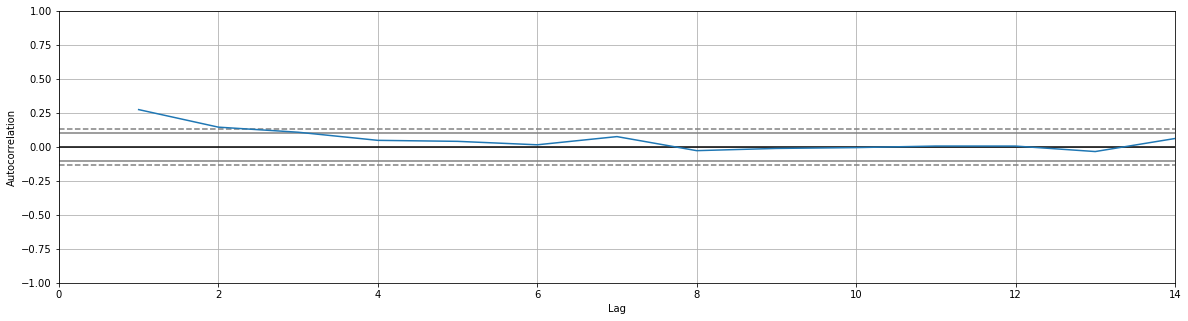

In [23]:
# Plotting Premade Autcorrelation Function (ACF)
plt.figure(figsize=(20,5))
autocorrelation_plot(daily_average_call_volume_medical_2018)
plt.xlim(0,14); # past two weeks 

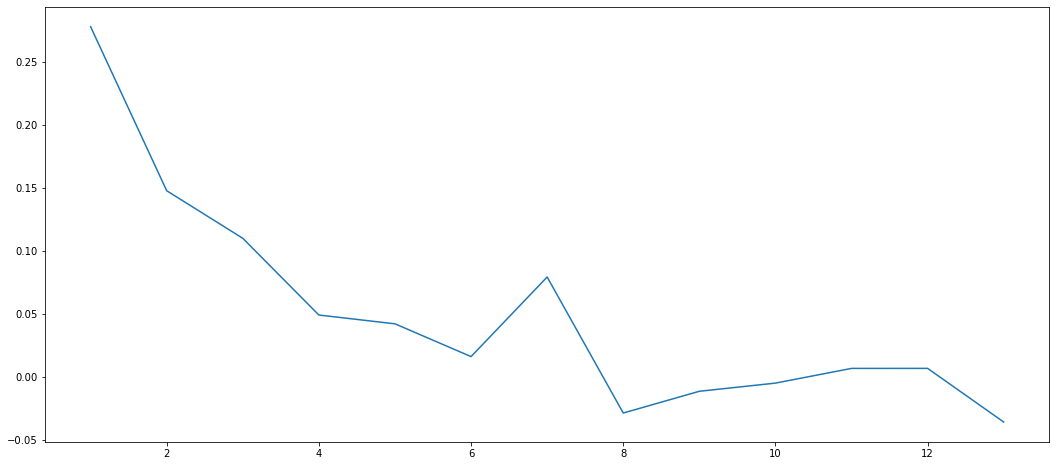

In [26]:
# Replicating Code for Premade ACF

# Manually Calculating lags from 1 to 14 days
lag_list = []
for i in range(1,14):
    lag_list.append(daily_average_call_volume_medical_2018.autocorr(lag=i))
    
# Manually Plotting correlations with lags
sns.lineplot(range(1,14),lag_list)

### Daily Decomposition

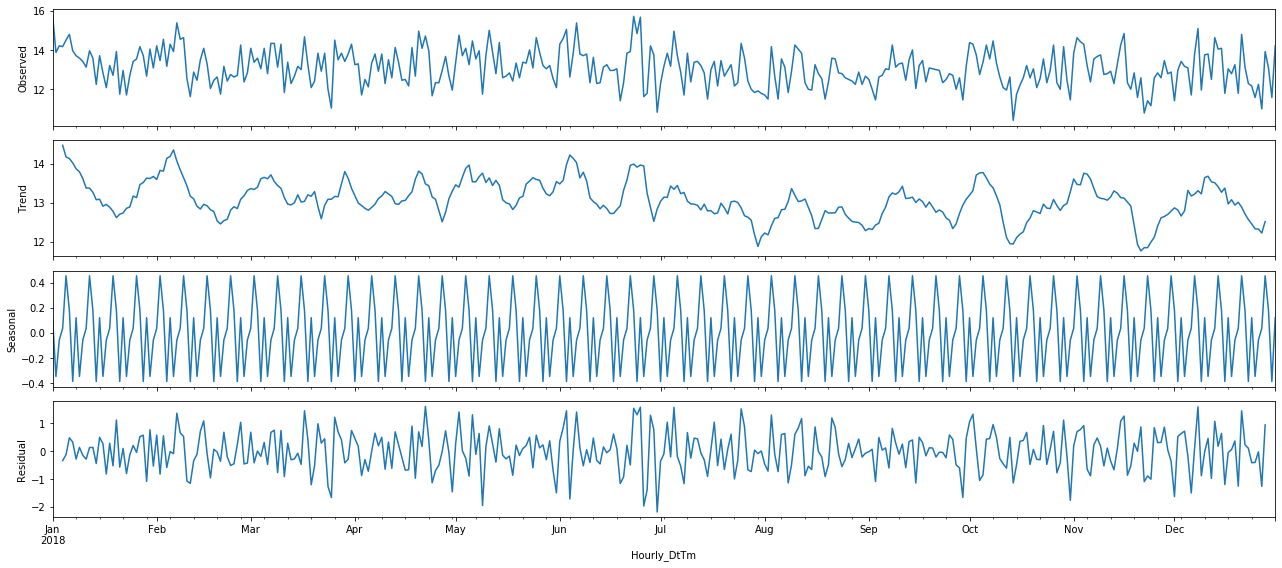

In [536]:
# Decomposing All of 2018 to find the underlying seasonality(weekly high and low) and trend
decomposition = seasonal_decompose(daily_average_call_volume_medical_2018, model='additive')
decomposition.plot();

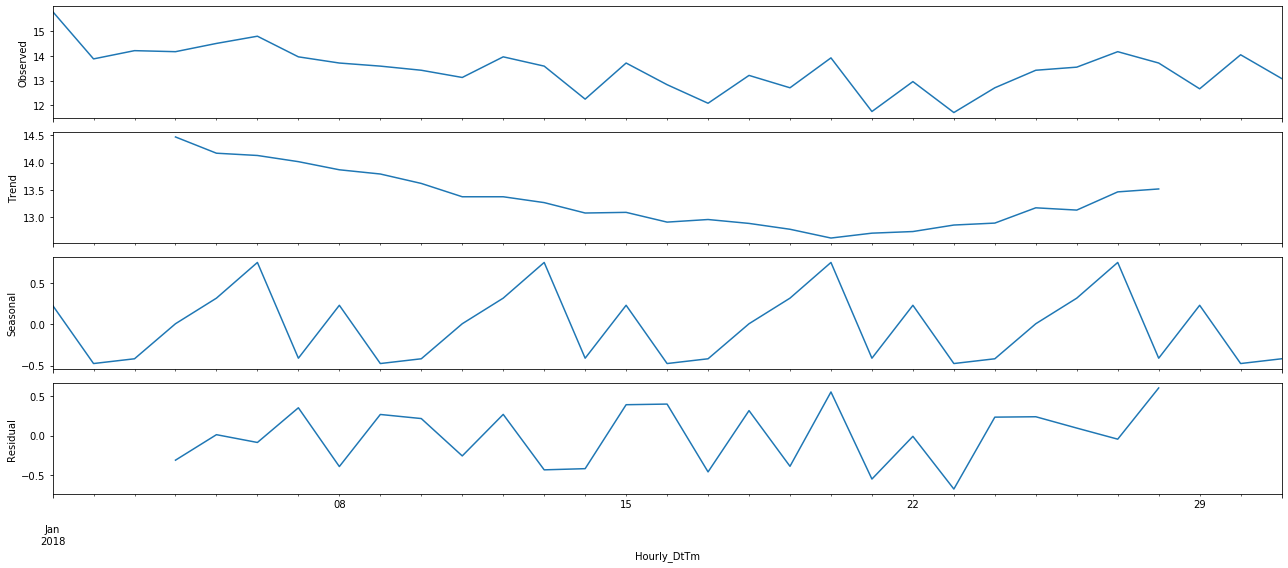

In [540]:
# Decomposing Only Jan 2018 to find the underlying seasonality(weekly high and low) and trend(dip 2/3 through month)
decomposition = seasonal_decompose(daily_average_call_volume_medical_2018[:31], model='additive')
decomposition.plot();

### Daily Violin Plot

In [523]:
violin_daily_average_call_volume_medical_2018 = daily_average_call_volume_medical_2018.copy()

In [524]:
violin_daily_average_call_volume_medical_2018.index = daily_average_call_volume_medical_2018.index.dayofweek

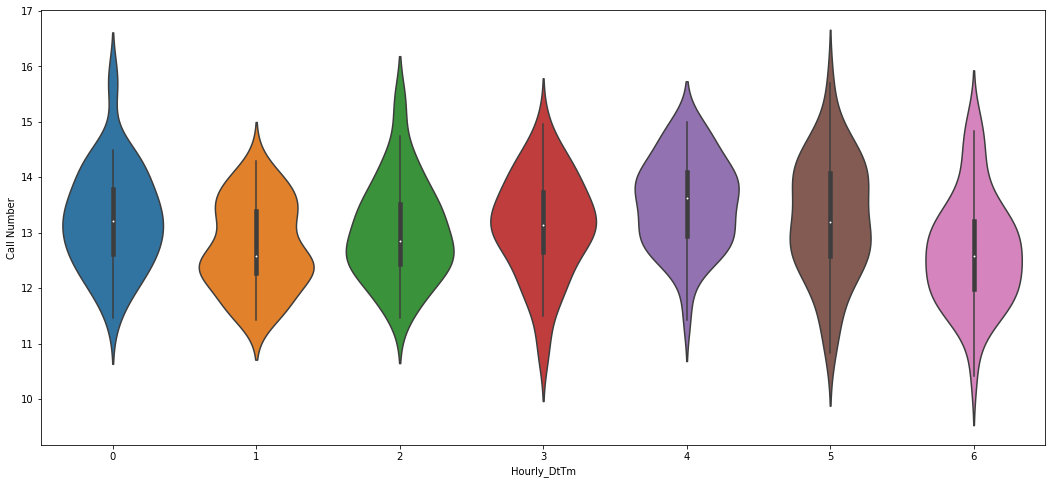

In [525]:
sns.violinplot(x=violin_daily_average_call_volume_medical_2018.index, y=violin_daily_average_call_volume_medical_2018)

### Checking for stationarity in data

In [27]:
# Looking at standard deviations in data 
# after taking derivatives several times.
# We want the standard deviation to be as low as possible
# The normal and 1st derivative are very close
# (1st derivative is better) but we could pick either
print('Normal:',hourly_call_volume_medical_2018.std())
print('1st Derivative:',hourly_call_volume_medical_2018.diff().std())
print('2nd Derivative:',hourly_call_volume_medical_2018.diff().diff().std())

Normal: 5.419892379592953
1st Derivative: 5.27467711134557
2nd Derivative: 8.888856031546311


In [715]:
# Dickey-Fuller Test (DFT) function - Check for stationarity
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=72).mean()
    rolstd = timeseries.rolling(window=72).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -1.357363e+01
p-value                 2.190759e-25
Lags Used               3.400000e+01
Observations Used       8.725000e+03
Critical Value (1%)    -3.431100e+00
Critical Value (5%)    -2.861871e+00
Critical Value (10%)   -2.566946e+00
dtype: float64


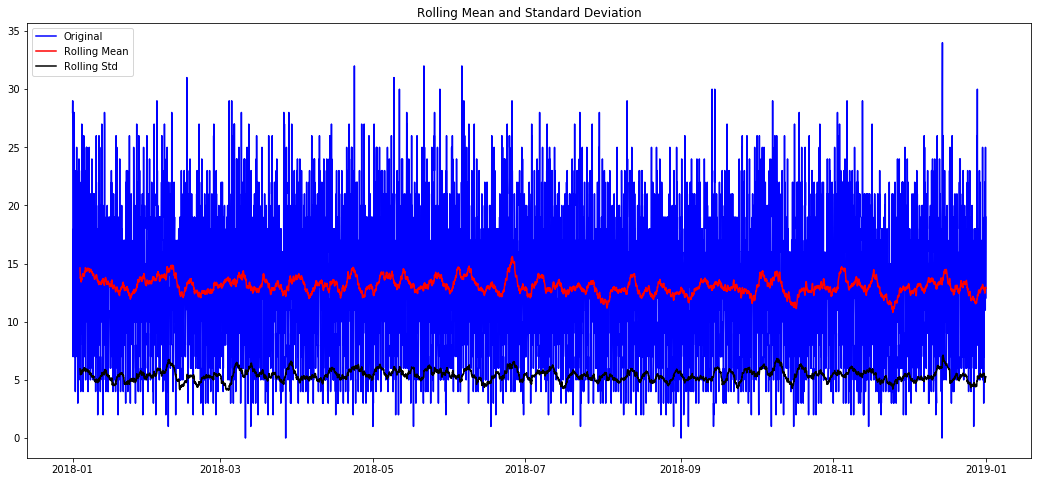

In [716]:
# Checking stationarity on hourly call volume data
dftest(hourly_call_volume_medical_2018)
# Since p-value is very small, we can reject the null hypothesis. The data is stationary.

In [28]:
def correlation_plots(data, lags=None):
    '''
    Returns visualizations for raw data,
    Autocorrelation Function, and Partial 
    Autocorrelation Function
    '''
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

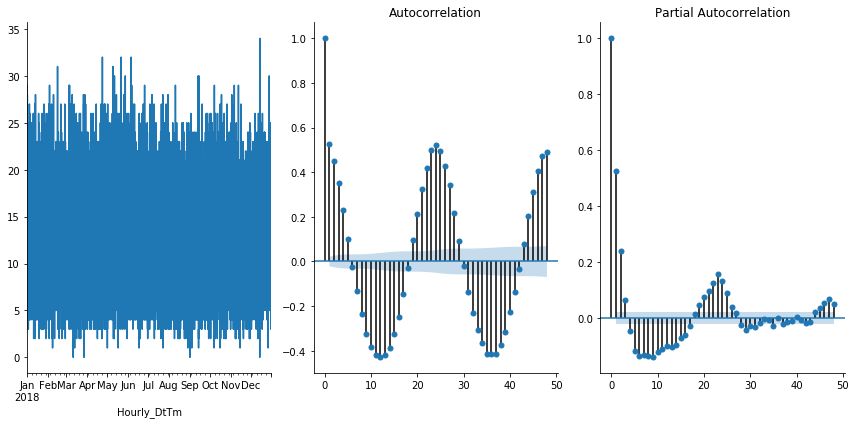

In [31]:
# Plotting ACF and PACF for hourly call volume data
correlation_plots(hourly_call_volume_medical_2018, lags=48);
# There is clear seasonality (suspension bridge appearance) indicating we should use SARIMA 

## Modeling

### ARIMA

                              ARMA Model Results                              
Dep. Variable:            Call Number   No. Observations:                 8760
Model:                     ARMA(1, 0)   Log Likelihood              -25814.353
Method:                       css-mle   S.D. of innovations              4.608
Date:                Mon, 10 Jun 2019   AIC                          51634.707
Time:                        11:22:05   BIC                          51655.940
Sample:                    01-01-2018   HQIC                         51641.942
                         - 12-31-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.0935      0.104    125.942      0.000      12.890      13.297
ar.L1.Call Number     0.5265      0.009     57.923      0.000       0.509       0.544
                        

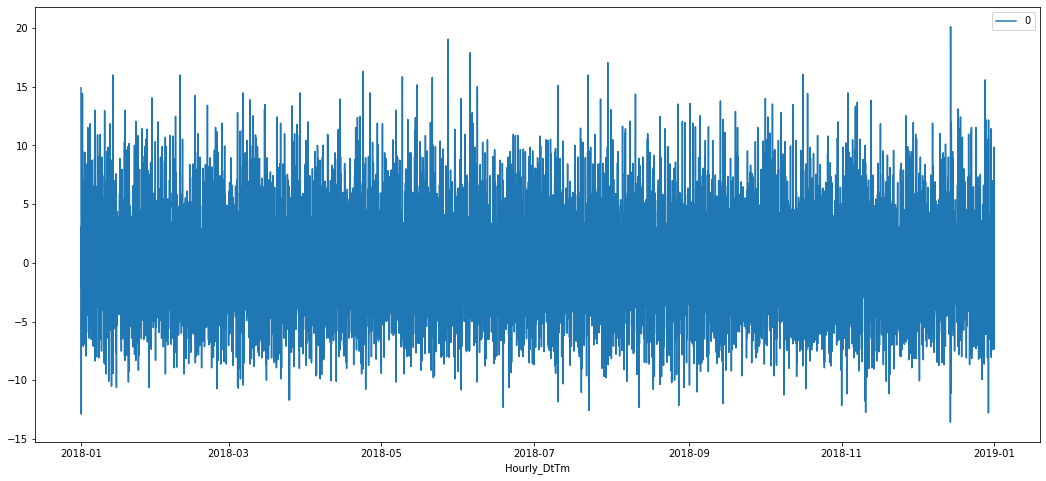

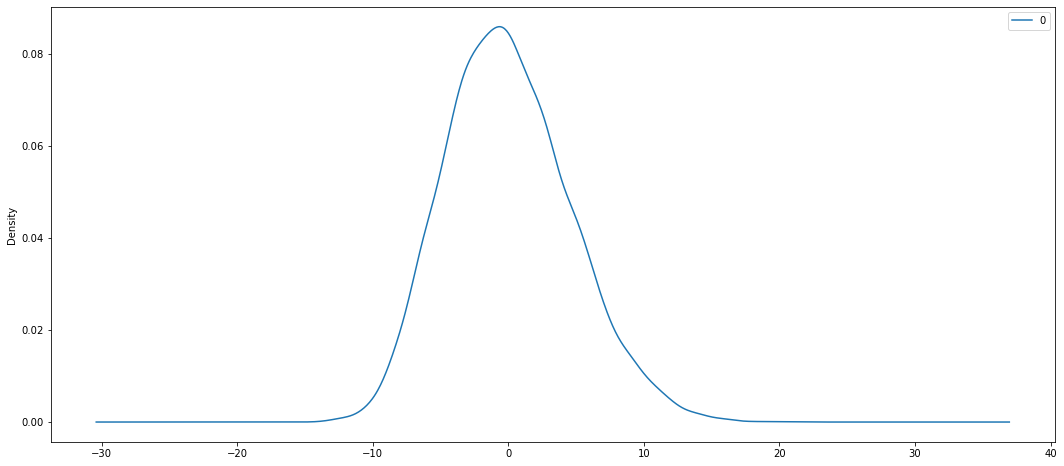

                 0
count  8760.000000
mean     -0.000897
std       4.609454
min     -13.570736
25%      -3.359099
50%      -0.306190
75%       2.955719
max      20.114446


In [782]:
# ARIMA on entire data set - No test_train split

# fit model
model = ARIMA(hourly_call_volume_medical_2018, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plotting residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize=(20,5))
sns.lineplot(data=residuals)
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [879]:
# ARIMA with test-train split and 
# growing window for train set
X = hourly_call_volume_medical_2018.values[:722] # 
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

predicted=13.824698, expected=14.000000
predicted=13.825066, expected=16.000000
predicted=14.725479, expected=17.000000
predicted=15.179452, expected=13.000000
predicted=13.381992, expected=13.000000
predicted=13.381188, expected=8.000000
predicted=11.129612, expected=10.000000
predicted=12.021737, expected=6.000000
predicted=10.203377, expected=6.000000
predicted=10.177380, expected=8.000000
predicted=11.071068, expected=4.000000
predicted=9.215676, expected=10.000000
predicted=11.957148, expected=13.000000
predicted=13.326833, expected=17.000000
predicted=15.156009, expected=16.000000
predicted=14.702818, expected=13.000000
predicted=13.332694, expected=13.000000
predicted=13.332014, expected=13.000000
predicted=13.331335, expected=12.000000
predicted=12.873216, expected=14.000000
predicted=13.786241, expected=14.000000
predicted=13.786672, expected=11.000000
predicted=12.415437, expected=14.000000
predicted=13.784096, expected=17.000000
predicted=15.155634, expected=8.000000
predict

predicted=16.004057, expected=13.000000
predicted=13.259595, expected=13.000000
predicted=13.259214, expected=19.000000
predicted=16.002201, expected=16.000000
predicted=14.634892, expected=12.000000
predicted=12.808504, expected=14.000000
predicted=13.721028, expected=15.000000
predicted=14.178266, expected=12.000000
predicted=12.809252, expected=7.000000
predicted=10.522118, expected=5.000000
predicted=9.587649, expected=13.000000
predicted=13.252723, expected=8.000000
predicted=10.964666, expected=7.000000
predicted=10.495914, expected=6.000000
predicted=10.021518, expected=6.000000
predicted=10.004690, expected=9.000000
predicted=11.382063, expected=8.000000
predicted=10.912730, expected=9.000000
predicted=11.369028, expected=14.000000
predicted=13.681307, expected=15.000000
predicted=14.144450, expected=11.000000
predicted=12.295615, expected=18.000000
predicted=15.527483, expected=20.000000
predicted=16.461270, expected=18.000000
predicted=15.543077, expected=22.000000
predicted=

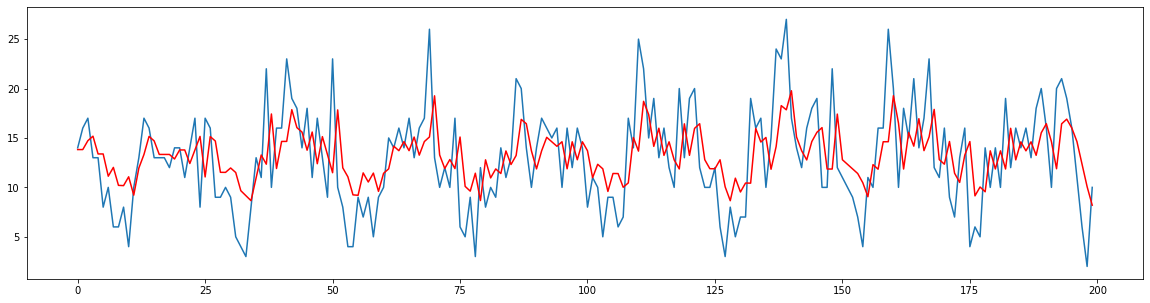

In [880]:
# plot ARIMA
plt.figure(figsize=(20,5))
plt.plot(test[:200])
plt.plot(predictions[:200], color='red')
plt.show()

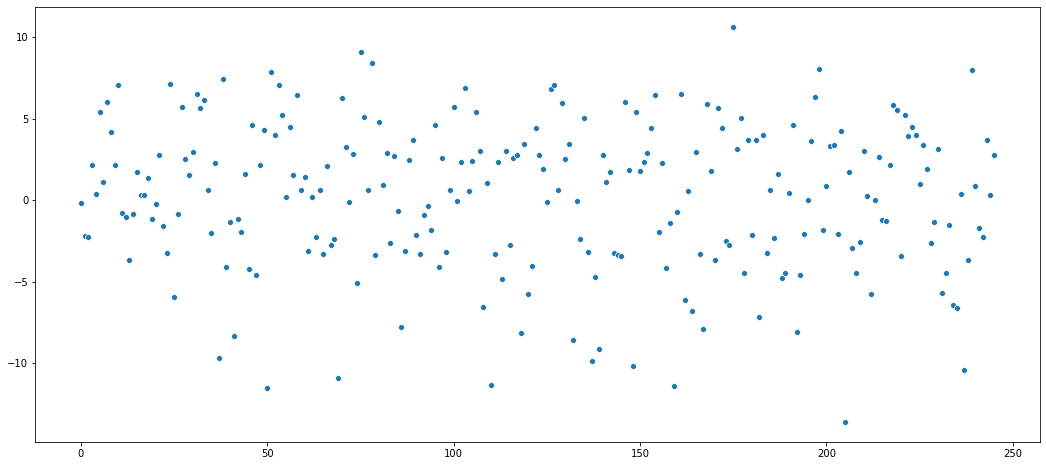

In [813]:
# Checking for residuals (look evenly distributed)
# plt.figure()
sns.scatterplot(x=(range(len(test))),y=[float(x) for x in predictions]-test)

### SARIMA Train-Test Split Only

In [ ]:
### SARIMA
# Relabeling time series data
X = hourly_call_volume_medical_2018.values #722

# Creating 67-33 Train-Test split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# Accumulator variable assignments
history = [x for x in train]
predictions = list()

# Loop for predicting the next value using previous data
for t in range(len(test)):
    # Instantiating model
    model = SARIMAX(history,order=(3,1,1),
                    seasonal_order=(1,0,1,24),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    # Training Model
    model_fit = model.fit()
    
    # Predicting one step into future and adding to prediction list
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    # Appending actual test observation to train data
    # so that on the next iteration, the model will train 
    # on all previous data and the next time step
    obs = test[t]
    history.append(obs)
    
    # Displaying predicted vs actual values
    print('predicted=%f, expected=%f' % (yhat, obs))

# Calculating and printing MSE for all test predictions    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
# Pickling best_sarima_model_fit
redo_pickle = False

if redo_pickle == True:
    with open('best_sarima_model_fit.pickle','wb') as f:
        pickle.dump(model_fit,f)
        
if redo_pickle == False:
    with open('best_sarima_model_fit.pickle','rb') as f:
        model_fit = pickle.load(f)

In [ ]:
# Pickling  best_sarima_model
redo_pickle = False

if redo_pickle == True:
    with open('best_sarima_model.pickle','wb') as f:
        pickle.dump(model,f)
        
if redo_pickle == False:
    with open('best_sarima_model.pickle','rb') as f:
        model = pickle.load(f)

In [3]:
# Pickling sarima_predictions
redo_pickle = False

if redo_pickle == True:
    with open('sarima_predictions.pickle','wb') as f:
        pickle.dump(predictions,f)
        
if redo_pickle == False:
    with open('sarima_predictions.pickle','rb') as f:
        predictions = pickle.load(f)

In [5]:
# Pickling sarima_test
redo_pickle = False

if redo_pickle == True:
    with open('sarima_test.pickle','wb') as f:
        pickle.dump(test[:436],f)
        
if redo_pickle == False:
    with open('sarima_test.pickle','rb') as f:
        test = pickle.load(f)

In [14]:
# Calculating and printing MSE for all test predictions    
error = mean_squared_error(test[:436], predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 3.508


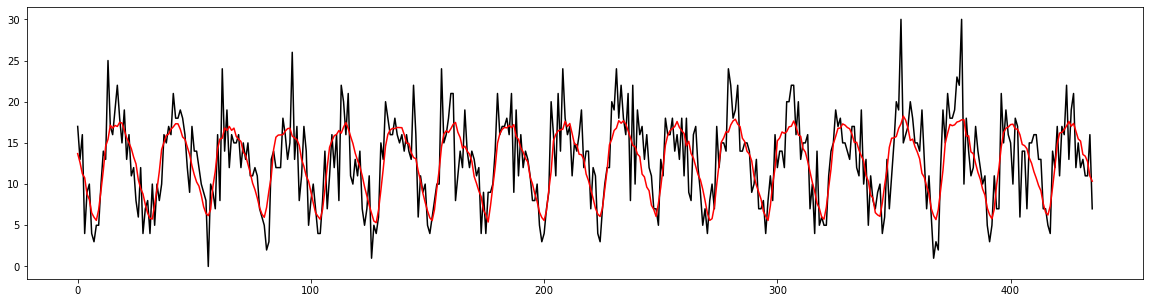

In [15]:
# plot SARIMA
plt.figure(figsize=(20,5))
plt.plot(test[:436], color='black')
plt.plot(predictions, color='red')
plt.show()

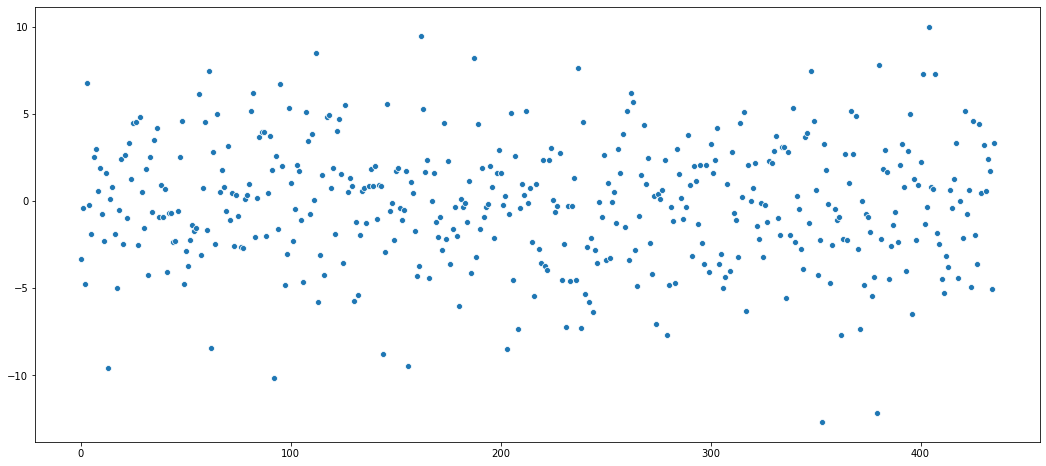

In [12]:
# Checking for residuals (look evenly distributed)
sns.scatterplot(x=(range(len(test[:436]))),y=[float(x) for x in predictions]-test[:436])

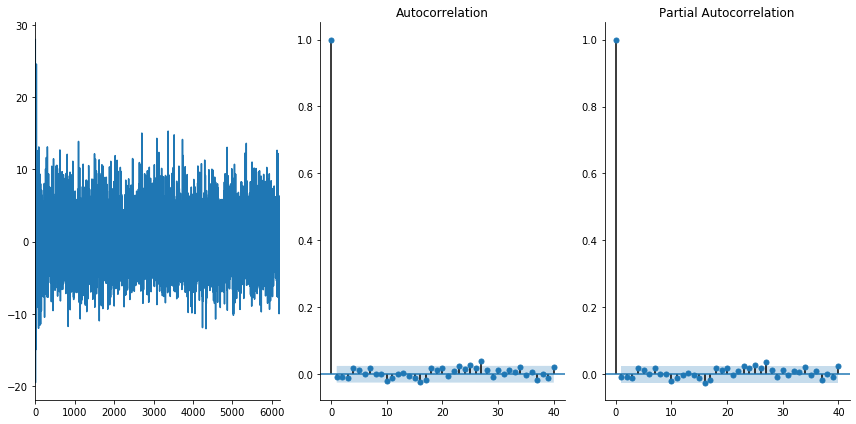

In [990]:
# Plotting ACF and PACF of Residuals for ARIMA
correlation_plots(pd.Series(model_fit.resid), lags=40);
# There is no more information to extract from the data
# since the residuals show no statistically significant 
# correlations with the data

In [1017]:
for x,y in zip(model_fit.param_terms,model_fit.params):
    print(x,y)

ar 0.06596343593967544
ma 0.051793942922233785
seasonal_ar 0.048370433272035454
seasonal_ma -0.9979784621223932
variance 0.99986898185224


### SARIMA Train-Validation-Test Split

In [33]:
def train_val_test_split(data):
    '''Returns 60-20-20 train-validation-test split'''
    size_train_test = int(len(data) * 0.8)
    train, test = data[:size_train_test], data[size_train_test:]
    size_train_val = int(len(train) * 0.75)
    train, val = train[:size_train_val], train[size_train_val:]
    print('Train:',len(train))
    print('Validation:',len(val))
    print('Test:',len(test))
    return train, val, test

In [35]:
# Creating 60-20-20 test train split
hourly_med_2018_train, hourly_med_2018_val, hourly_med_2018_test = train_val_test_split(hourly_call_volume_medical_2018.values)

Train: 5256
Validation: 1752
Test: 1752


In [ ]:
### SARIMA Model with train and validation sets (growing window)

# Accumulator variable assignments
history = [x for x in hourly_med_2018_train]
predictions = list()

# Loop for predicting the next value using previous data
for t in range(len(hourly_med_2018_val)):
    # Instantiating model
    model = SARIMAX(history,order=(3,1,1),
                    seasonal_order=(1,0,1,24),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    # Training Model
    model_fit = model.fit()
    
    # Predicting one step into future and adding to prediction list
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    # Appending actual test observation to train data
    # so that on the next iteration, the model will train 
    # on all previous data and the next time step
    obs = test[t]
    history.append(obs)
    
    # Displaying predicted vs actual values
    print('predicted=%f, expected=%f' % (yhat, obs))

# Calculating and printing MSE for all test predictions    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.572543, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.865193, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.200122, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.158633, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.598730, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.508383, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.655962, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.847921, expected=3.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.368923, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.627904, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.181036, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.049711, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.133725, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.302761, expected=25.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.171690, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.128549, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.147104, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.125283, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.944458, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.757243, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.898231, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.054376, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.849809, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.814627, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.144619, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.281830, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.490848, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.773531, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.547910, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.929196, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.609892, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.696466, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.335003, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.196980, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.342173, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.223195, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.486613, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.926247, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.781565, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.310313, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.062910, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.915060, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.755576, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.541520, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.075936, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.160948, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.397613, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.038112, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.545540, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.087710, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.090014, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.637419, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.414833, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.286870, expected=10.000000
predicted=8.355432, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.393826, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.881362, expected=0.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.899459, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.239614, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.621016, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.981692, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.365803, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.037091, expected=24.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.177304, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.235873, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.487845, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.012935, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.135769, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.229230, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.533975, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.951407, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.388905, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.678596, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.370567, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.549550, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.668683, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.258858, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.050945, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.331494, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.189978, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.488708, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.492805, expected=2.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.462324, expected=3.000000
predicted=13.799161, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.720560, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.906237, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.986111, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.165251, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.336208, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.658464, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.265532, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.953189, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.288188, expected=26.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.261681, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.201004, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.397628, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.900016, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.189156, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.192404, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.049092, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.985274, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.606565, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.752124, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.800018, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.163267, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.780478, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.476529, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.875630, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.996891, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.862814, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.509070, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.007031, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.900774, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.951756, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.510124, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.218495, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.104287, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.275147, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.843340, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.294184, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.851408, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.123854, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.198395, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.276804, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.518849, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.166546, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.630748, expected=1.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.146310, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.627219, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.199184, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.366047, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.570834, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.265684, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.018993, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.250676, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.980112, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.085226, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.101148, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.501122, expected=15.000000


In [14]:
# Calculating and printing MSE for all test predictions    
error = mean_squared_error(test[:436], predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 3.508


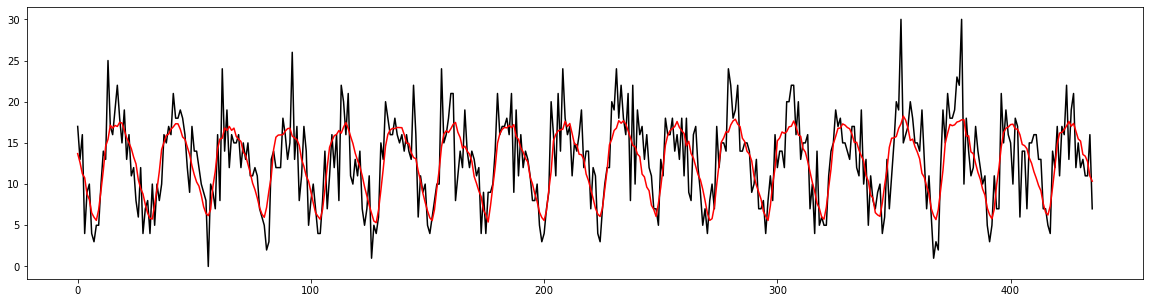

In [15]:
# plot SARIMA
plt.figure(figsize=(20,5))
plt.plot(test[:436], color='black')
plt.plot(predictions, color='red')
plt.show()

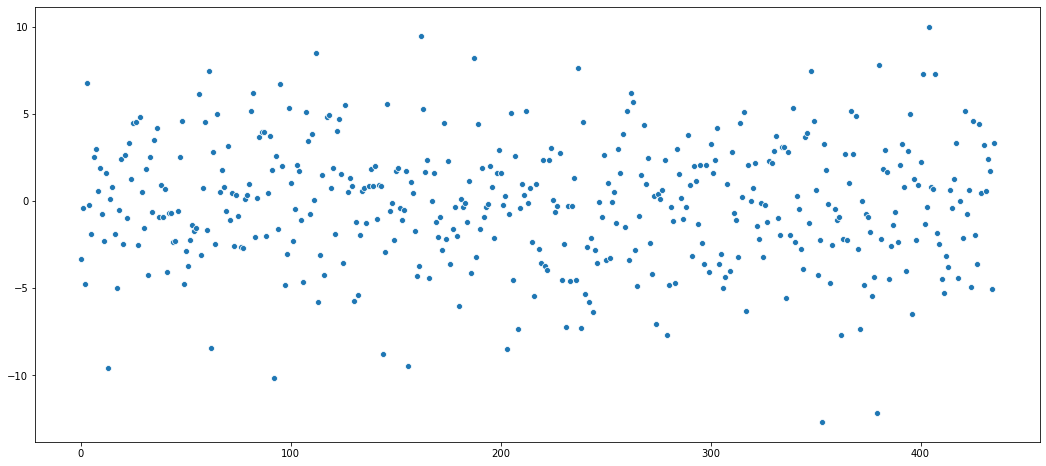

In [12]:
# Checking for residuals (look evenly distributed)
sns.scatterplot(x=(range(len(test[:436]))),y=[float(x) for x in predictions]-test[:436])

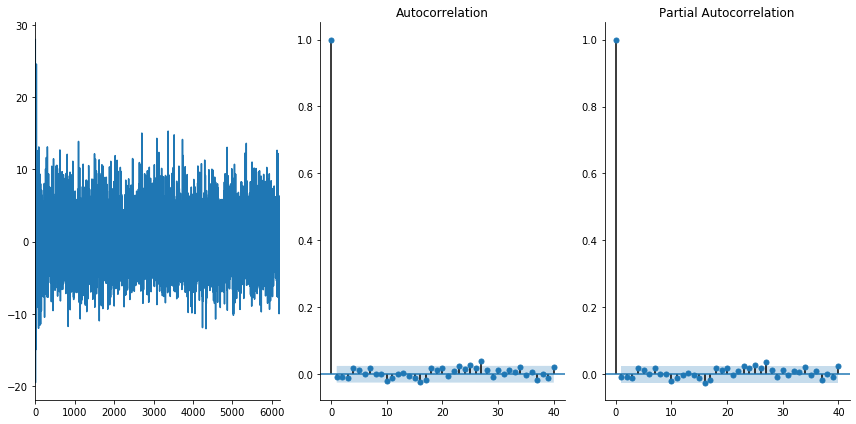

In [990]:
# Plotting ACF and PACF of Residuals for ARIMA
correlation_plots(pd.Series(model_fit.resid), lags=40);
# There is no more information to extract from the data
# since the residuals show no statistically significant 
# correlations with the data

In [1017]:
for x,y in zip(model_fit.param_terms,model_fit.params):
    print(x,y)

ar 0.06596343593967544
ma 0.051793942922233785
seasonal_ar 0.048370433272035454
seasonal_ma -0.9979784621223932
variance 0.99986898185224
